In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import chi2

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
train = pd.read_csv('/content/sample_data/train.csv')
test = pd.read_csv('/content/sample_data/test.csv')

In [ ]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [ ]:
train.isna().sum()

,0
Item_Identifier,0
Item_Weight,1463
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,2410
Outlet_Location_Type,0


In [ ]:
for i in train.columns:
  print(f"column: {i}: no_of_unique_values: {train[i].nunique()} : {train[i].unique()}")

column: Item_Identifier: no_of_unique_values: 1559 : ['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']
column: Item_Weight: no_of_unique_values: 415 : [ 9.3    5.92  17.5   19.2    8.93  10.395 13.65     nan 16.2   11.8
 18.5   15.1   17.6   16.35   9.    13.35  18.85  14.6   13.85  13.
  7.645 11.65   5.925 19.25  18.6   18.7   17.85  10.     8.85   9.8
 13.6   21.35  12.15   6.42  19.6   15.85   7.39  10.195  9.895 10.895
  7.905  9.195  8.365  7.97  17.7   19.35   8.645 15.6   18.25   7.855
  7.825  8.39  12.85  19.     5.905  7.76  16.75  15.5    6.055  6.305
 20.85  20.75   8.895 19.7    8.75  13.3    8.31  19.75  17.1   10.5
  6.635 14.15   8.89   9.1    7.5   16.85   7.485 11.6   12.65  20.25
  8.6   12.6    8.88  20.5   13.5    7.235  6.92   8.02  12.8   16.6
 14.    16.    21.25   7.365 18.35   5.465  7.27   6.155 19.5   15.2
 14.5   13.1   12.3   11.1   11.3    5.75  11.35   6.525 10.3    5.78
 11.85  18.75   5.26  16.1    9.5   13.8   14.65   6.67   6.11  17.2
  6.32   4

<Axes: xlabel='Item_Outlet_Sales', ylabel='Count'>

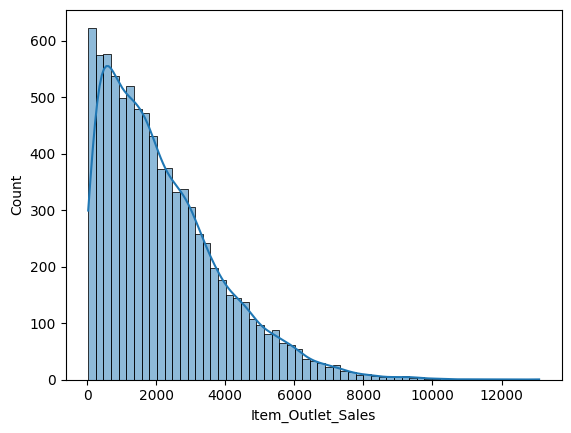

In [ ]:
sns.histplot(train['Item_Outlet_Sales'],kde = True)

<Axes: ylabel='Item_Visibility'>

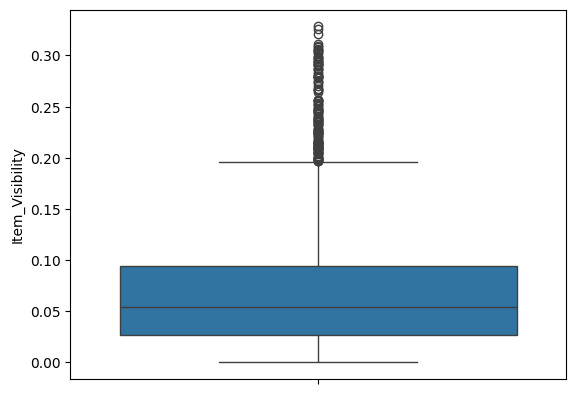

In [ ]:

sns.boxplot(train['Item_Visibility'])

<Axes: ylabel='Item_Visibility'>

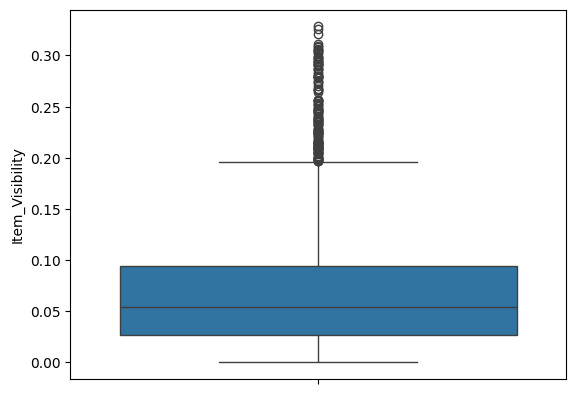

In [ ]:
sns.boxplot(train['Item_Visibility'])

In [ ]:
num_cols = train.select_dtypes(include = np.number).columns.tolist()
num_cols

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Item_Outlet_Sales']

<Axes: ylabel='Item_Weight'>

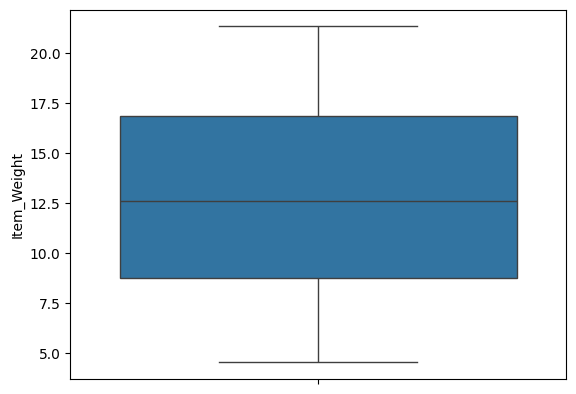

In [ ]:

sns.boxplot(train['Item_Weight'])

<Axes: ylabel='Item_MRP'>

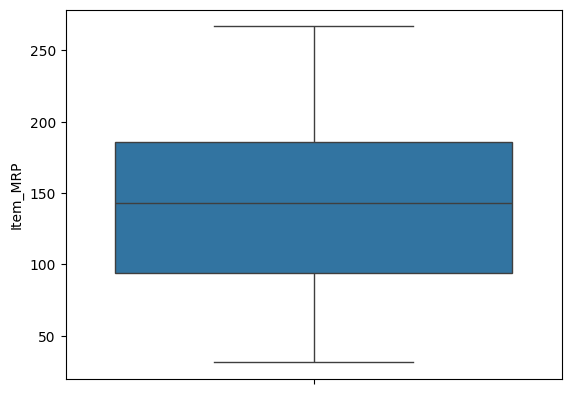

In [ ]:
sns.boxplot(train['Item_MRP'])

<Axes: ylabel='Outlet_Establishment_Year'>

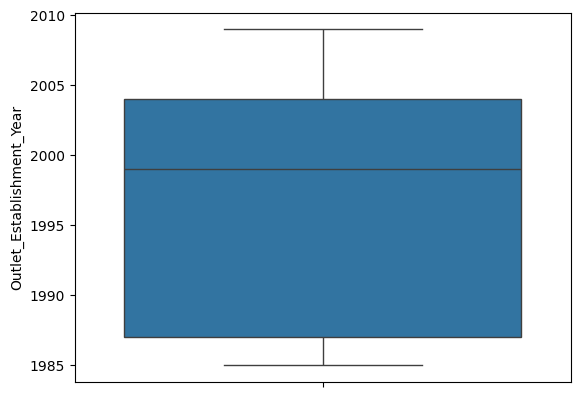

In [ ]:
sns.boxplot(train['Outlet_Establishment_Year'])

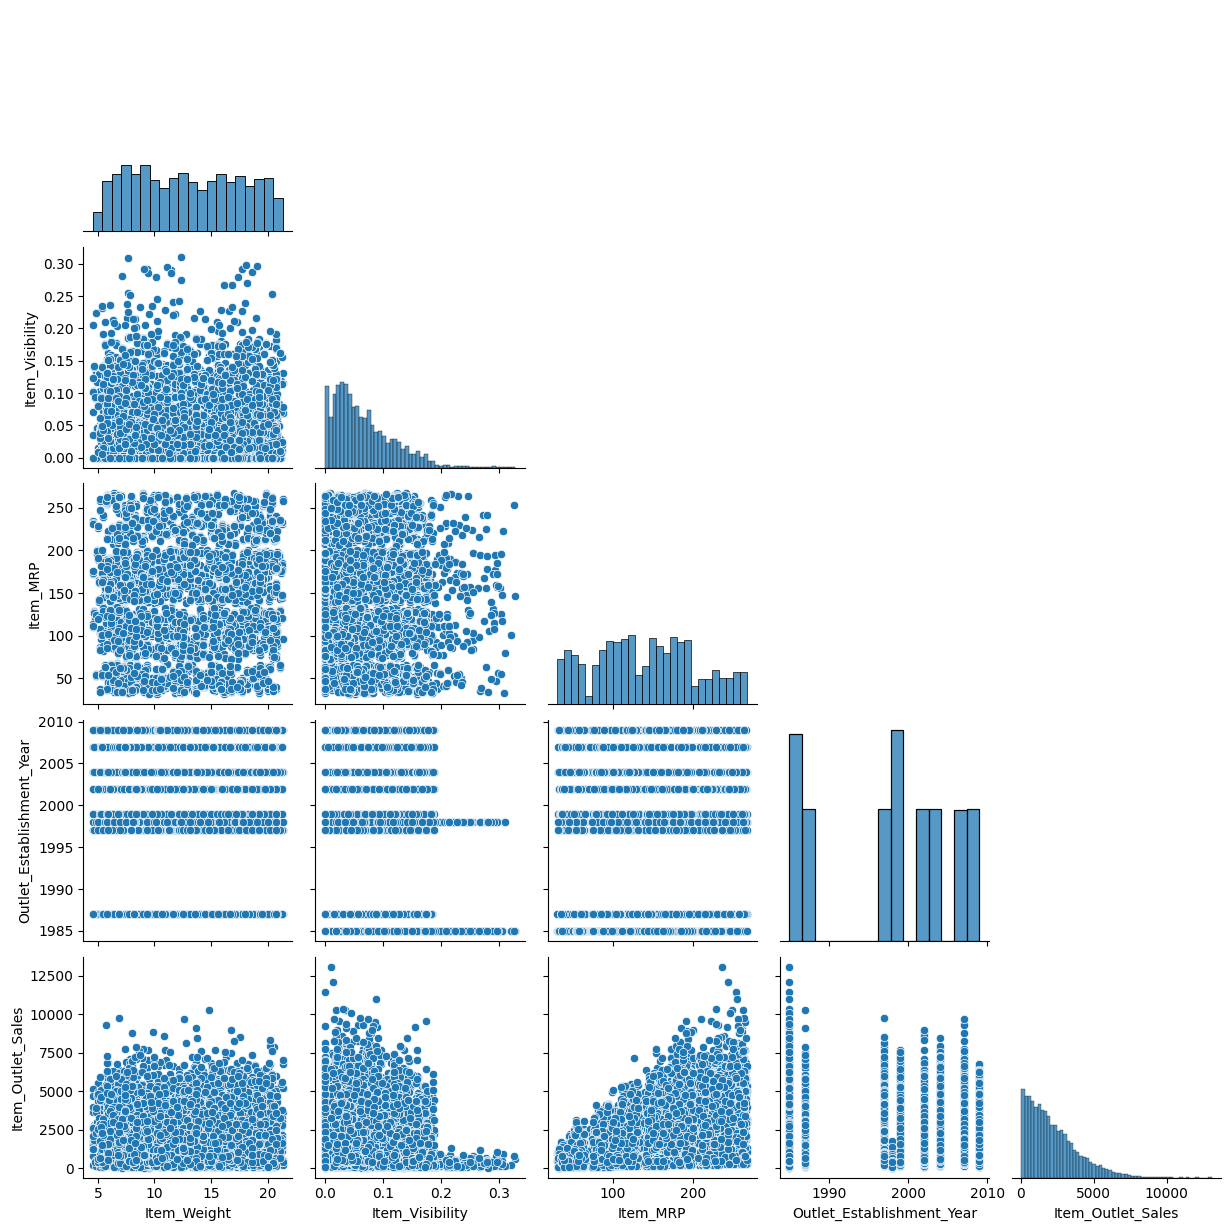

In [ ]:
sns.pairplot(train[num_cols],corner = True)

In [ ]:

CURRENT_YEAR = 2013
for df in [train, test]:
    # Standardize labels
    df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'})

    # Fill missing
    df['Item_Weight'].fillna(df['Item_Weight'].mean(), inplace=True) #Global Mean fix - GroupBy Appropriate categories and take group median Assignment
    df['Item_Visibility'] = df['Item_Visibility'].replace(0, df['Item_Visibility'].median()) #Global Median fix - GroupBy Appropriate categories and take group median Assignment
    df['Outlet_Size'].fillna(df['Outlet_Size'].mode()[0], inplace=True) #Global Mode fix - GroupBy Appropriate categories and take group median Assignment

    df['Item_Category'] = df['Item_Identifier'].apply(lambda x: x[:2])
    df['Outlet_age'] = CURRENT_YEAR - df['Outlet_Establishment_Year']
    df['Visibility_MeanRatio'] = df['Item_Visibility'] / df['Item_Visibility'].mean() #Still prossible grouping but here both seem fine - Grouping by the outlet visibility
    #Categorizing item visibility - Low / High
    df['Outlet_Location_Score'] = df['Outlet_Location_Type'].map({"Tier 1":1,"Tier 2":2,"Tier 3":3})
    df['High_MRP_Flag'] = (df['Item_MRP'] > df['Item_MRP'].median()).astype(int)

    #df['Outlet_MRP_Avg'] = df.groupby('Outlet_Identifier')['Item_MRP'].transform('mean')
    #df['Relative_MRP'] = df['Item_MRP'] / df['Outlet_MRP_Avg']

In [ ]:
train.to_csv("preprocessed_train.csv", index = False)
test.to_csv("preprocessed_test.csv", index = False)

In [ ]:
train[num_cols].corr()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.000000,-0.016533,0.024756,-0.008301,0.011550
Item_Visibility,-0.016533,1.000000,-0.004531,-0.078271,-0.134095
Item_MRP,0.024756,-0.004531,1.000000,0.005020,0.567574
Outlet_Establishment_Year,-0.008301,-0.078271,0.005020,1.000000,-0.049135
Item_Outlet_Sales,0.011550,-0.134095,0.567574,-0.049135,1.000000


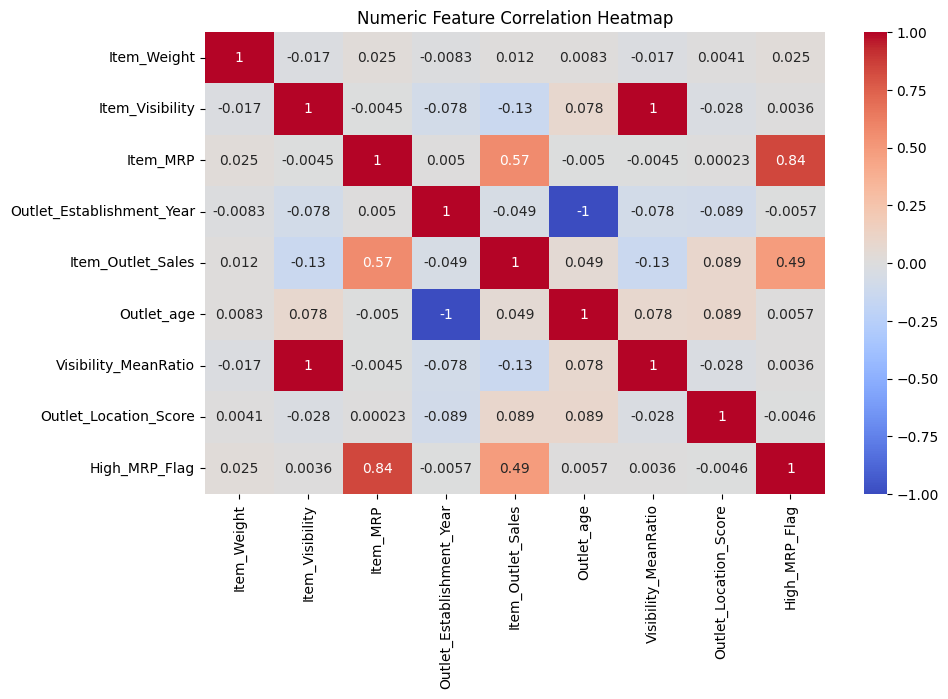

In [ ]:
# Correlation heatmap (numeric features) Pearson Coefficent
num_cols = train.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(10,6))
sns.heatmap(train[num_cols].corr(), cmap='coolwarm', annot=True)
plt.title("Numeric Feature Correlation Heatmap")
plt.show()

<Axes: xlabel='Item_Outlet_Sales', ylabel='Count'>

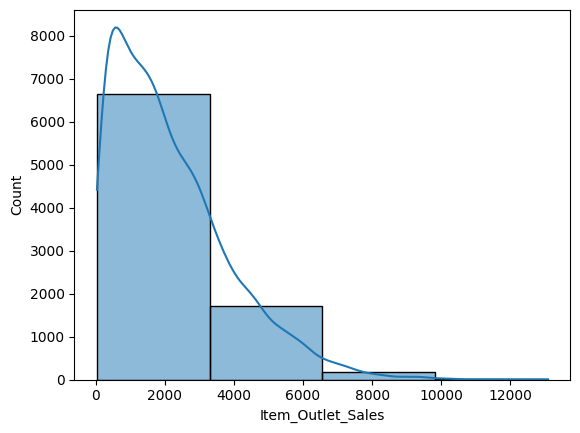

In [ ]:
sns.histplot(train['Item_Outlet_Sales'],kde = True,bins=4)

In [ ]:
# Chi-square test for categorical vs target
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency

cat_cols = train.select_dtypes(exclude=np.number).columns
chi_results = []

#Chi-Square is a test for variance
for c in cat_cols:
    contingency = pd.crosstab(train[c], pd.qcut(train["Item_Outlet_Sales"], q=4)) #4Quartilee
    chi2_stat, p, dof, ex = chi2_contingency(contingency)
    chi_results.append((c, chi2_stat, p))
    #H0 - No association between each categorical variable and binned sales
    #HA - Strong Relationship (p<0.05) reject Null
chi_df = pd.DataFrame(chi_results, columns=["Feature","Chi2","p_value"]).sort_values("p_value")
print("Chi-Square association with Item_Outlet_Sales (lower p = stronger association):")
display(chi_df)

Chi-Square association with Item_Outlet_Sales (lower p = stronger association):


,Feature,Chi2,p_value
3,Outlet_Identifier,3679.210196,0.000000e+00
6,Outlet_Type,3647.922343,0.000000e+00
0,Item_Identifier,7454.138969,1.486821e-132
5,Outlet_Location_Type,282.177067,5.372026e-58
4,Outlet_Size,119.632597,1.946431e-23
7,Item_Category,27.515132,1.159189e-04
2,Item_Type,88.372933,1.204309e-04
1,Item_Fat_Content,5.429388,1.429235e-01


In [ ]:
target = "Item_Outlet_Sales"

features = ["Item_Weight",'Item_Visibility','Item_MRP','Outlet_age','Outlet_Location_Score','Item_Type','Item_Category',
            'Outlet_Size','Outlet_Location_Type','Outlet_Type','Outlet_Identifier']

X = train[features]
y = train[target]

X_test = test[features]

num_cols = X.select_dtypes(include=np.number).columns
cat_cols = X.select_dtypes(exclude=np.number).columns

In [ ]:
preprocessor = ColumnTransformer([("num",StandardScaler(),num_cols),
                                  ("categorical", OneHotEncoder(handle_unknown="ignore", drop='first',sparse_output=False),cat_cols)])
lin_pipe = Pipeline([('prep',preprocessor),
                     ('model',LinearRegression())]) #Solves

In [ ]:
lin_pipe.fit(X,y) #Gradient descent is happening here..!
y_pred = lin_pipe.predict(X)

In [ ]:
r2 = r2_score(y,y_pred)
rmse = np.sqrt(mean_squared_error(y,y_pred))

In [ ]:
r2

0.5636337028454182

In [ ]:
rmse

np.float64(1127.2138485537246)

In [ ]:
preds = lin_pipe.predict(X_test)

preds = np.clip(preds,0,None)

submission = pd.DataFrame({'Item_Identifier':test['Item_Identifier'],
                           'Outlet_Identifier':test['Outlet_Identifier'],
                           'Item_Outlet_Sales': preds})

submission.to_csv("Submission_LR_CF.csv",index=False)

In [ ]:

from sklearn.linear_model import SGDRegressor #Learns - Random weights and optimizes

gd_lrmodel = SGDRegressor()
gd_lrmodel.fit(X,y)

ValueError: could not convert string to float: 'Dairy'